In [25]:
import sys
import matplotlib
#matplotlib.use('Agg')
import skimage.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import diff_classifier.aws as aws
from skimage.filters import roberts, sobel, scharr, prewitt, median, rank
from skimage import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, disk, reconstruction, remove_small_objects
from scipy.ndimage.morphology import distance_transform_edt as EuclideanTransform
from scipy.ndimage.morphology import binary_fill_holes as fill_holes
from operator import itemgetter

In [4]:
to_track = []
result_futures = {}

remote_folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]

for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            #to_track.append('100x_0_4_1_2_gel_{}_bulk_vid_{}'.format(vis, num))
            to_track.append('{}_{}_XY{}'.format(typ, slic, num))

In [26]:
def binary_BF(image, meanse=disk(10), edgefilt='prewitt', opense=disk(10),
          closese=disk(10), fill_first=False, bi_thresh=0.000025, min_size=200,
          fillse=disk(10)):
    
    #convertim = img_as_ubyte(image)
    meanim = rank.mean(image, meanse)
    if edgefilt is 'prewitt':
        edgeim = prewitt(meanim)
    elif edgefilt is 'sobel':
        edgeim = sobel(meanim)
    elif edgefilt is 'scharr':
        edgeim = scharr(meanim)
    elif edgefilt is 'roberts':
        edgeim = roberts(meanim)
    
    closeim = closing(edgeim, closese)
    openim = opening(closeim, opense)
    if fill_first:
        seed = np.copy(openim)
        seed[1:-1, 1:-1] = openim.max()
        mask = openim
        filledim = reconstruction(seed, mask, method='erosion')
        binarim = filledim > bi_thresh
    else:
        binarim = openim > bi_thresh*np.mean(openim)
        seed = np.copy(binarim)
        seed[5:-5, 5:-5] = binarim.max()
        mask = binarim
        #filledim = reconstruction(seed, mask, method='erosion', selem=fillse)
        filledim = fill_holes(mask, structure=fillse)
        
    tophim = remove_small_objects(filledim>0.01, min_size=min_size)

    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    ax[0][0].imshow(image, cmap='gray')
    ax[0][1].imshow(meanim, cmap='gray')
    ax[0][2].imshow(edgeim, cmap='gray', vmax=4*np.mean(edgeim))
    ax[0][3].imshow(closeim, cmap='gray', vmax=4*np.mean(closeim))
    ax[1][0].imshow(openim, cmap='gray', vmax=4*np.mean(openim))
    ax[1][1].imshow(binarim, cmap='gray')
    ax[1][2].imshow(filledim, cmap='gray')
    ax[1][3].imshow(tophim, cmap='gray')
    for axes in ax:
        for axe in axes:
            axe.axis('off')
    fig.tight_layout()
    
    return tophim

In [6]:
def BF_cell_features(prefix, folder, bucket='ccurtis.data'):
    
    ffilename = 'features_{}.csv'.format(prefix)
    mfilename = 'msd_{}.csv'.format(prefix)
    bffilename = 'BF_cells_{}.tif'.format(prefix)
    biim = 'bi_BF_cells_{}.tif'.format(prefix)
    bimages = 'biproc_BF_cells_{}.png'.format(prefix)
    
    aws.download_s3('{}/{}'.format(folder, ffilename), ffilename, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(folder, mfilename), mfilename, bucket_name=bucket)
    aws.download_s3('{}/{}'.format(folder, bffilename), bffilename, bucket_name=bucket)
    print('Successfully downloaded files')
    
    fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")
    msds = pd.read_csv(mfilename, encoding = "ISO-8859-1")
    bfimage = plt.imread(bffilename)
    tophimage = binary_BF(bfimage, opense=disk(12), bi_thresh=1.2, tophatse=disk(20))
    plt.savefig(bimages)
    euimage = EuclideanTransform(tophimage)+EuclideanTransform(~tophimage)
    print('Successfully performed image processing')
    
    xa = -np.reshape(np.clip((fstats.Y.values-1).astype(int), a_min=0, a_max=2043), newshape=(fstats.Y.shape[0], 1))
    ya = np.reshape(np.clip((fstats.X.values-1).astype(int), a_min=0, a_max=2043), newshape=(fstats.X.shape[0], 1))
    xya = [tuple(l) for l in np.concatenate((xa, ya), axis=1).tolist()]
    fstats['Cell Status'] = itemgetter(*xya)(tophimage)
    fstats['Cell Distance'] = itemgetter(*xya)(euimage)

    print('Successfully calculated Cell Status Params')
    
    frames = 651
    xb = -np.reshape(np.clip((msds.Y.values-1).astype(int), a_min=0, a_max=2043), newshape=(int(msds.Y.shape[0]), 1))
    yb = np.reshape(np.clip((msds.X.values-1).astype(int), a_min=0, a_max=2043), newshape=(int(msds.X.shape[0]), 1))
    xyb = [tuple(l) for l in np.concatenate((xb, yb), axis=1).tolist()]
    msds['Cell Status'] = itemgetter(*xyb)(tophimage)
    msds['Cell Distance'] = itemgetter(*xyb)(euimage)
    
    msds_cell_status = np.reshape(msds['Cell Status'].values, newshape=(int(msds['Cell Status'].shape[0]/frames), frames))
    msds_cell_distance = np.reshape(msds['Cell Distance'].values, newshape=(int(msds['Cell Distance'].shape[0]/frames), frames))
    fstats['Membrane Xing'] = np.sum(np.diff(msds_cell_status, axis=1) == True, axis=1)
    fstats['Distance Towards Cell'] = np.sum(np.diff(msds_cell_distance, axis=1), axis=1)
    fstats['Percent Towards Cell'] = np.mean(np.diff(msds_cell_distance, axis=1) > 0, axis=1)
    print('Successfully calculated Membrane Xing Params')
    
    fstats.to_csv(ffilename, sep=',', encoding = "ISO-8859-1")
    msds.to_csv(mfilename, sep=',', encoding = "ISO-8859-1")
    plt.imsave(biim, tophimage, cmap='gray')
    
    aws.upload_s3(ffilename, '{}/{}'.format(folder, ffilename), bucket_name=bucket)
    aws.upload_s3(mfilename, '{}/{}'.format(folder, mfilename), bucket_name=bucket)
    aws.upload_s3(biim, '{}/{}'.format(folder, biim), bucket_name=bucket)
    aws.upload_s3(bimages, '{}/{}'.format(folder, bimages, bucket_name=bucket))
    print('Successfully uploaded files')
    
    return fstats

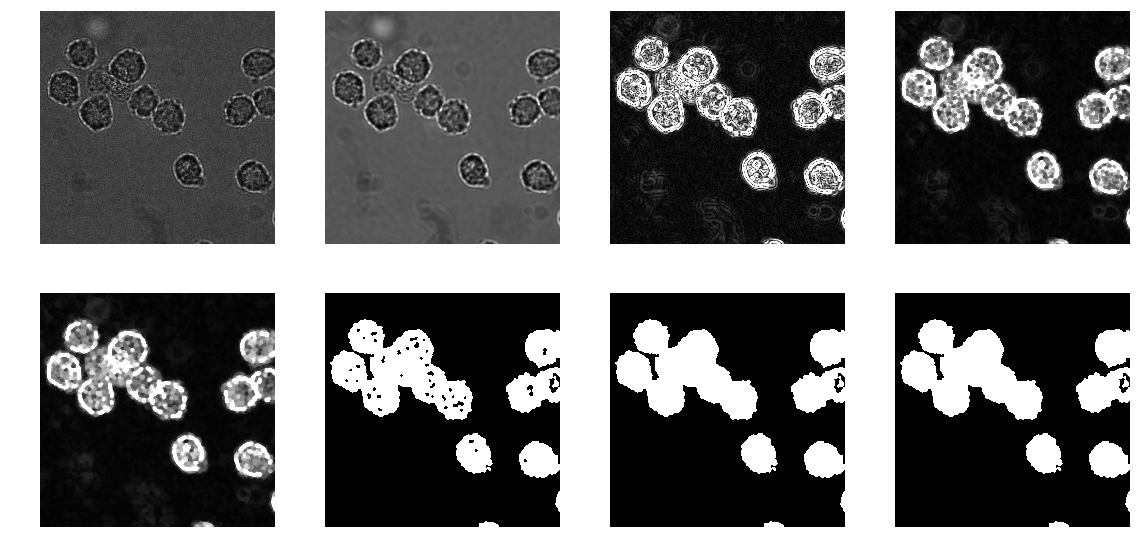

In [29]:
prefix = to_track[4]
#%matplotlib inline
bffilename = 'BF_cells_{}.tif'.format(prefix)
biim = 'bi_BF_cells_{}.tif'.format(prefix)
bimages = 'biproc_BF_cells_{}.png'.format(prefix)

bfimage = plt.imread(bffilename)
tophimage = binary_BF(bfimage, opense=disk(14), closese=disk(10), bi_thresh=1.4, fillse=disk(5))

In [50]:
import diff_classifier.knotlets as kn

In [51]:
prefix

'PS_1_XY3'

In [52]:
kn.assemble_msds(prefix, remote_folder, bucket=bucket)

Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not foun

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in double_scalars
  aspratio = width/height


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

/home/ubuntu/source/diff-classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (


Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters n

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
(19, 67)
(12, 67)
(20, 67)
(13, 67)
(35, 67)
(29, 67)


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:848: RuntimeWarning: Mean of empty slice
  datai['Mean '+ col][bitesize.index] = np.nanmean(bitesize[col])
/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(27, 67)
(30, 67)
(28, 67)
(36, 67)
(19, 67)
(22, 67)
(49, 67)
(31, 67)
(77, 67)
(187, 67)
(18, 67)
(28, 67)


/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1308: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


(33, 67)
(65, 67)
(54, 67)
(17, 67)
(28, 67)
(45, 67)
(31, 67)
(29, 67)
(27, 67)
(28, 67)
(95, 67)
(207, 67)
(136, 67)
(35, 67)
(16, 67)
(88, 67)
(171, 67)
(209, 67)
(119, 67)
(30, 67)
(21, 67)
(24, 67)
(30, 67)
(20, 67)
(42, 67)
(39, 67)
(487, 67)
(692, 67)
(706, 67)
(234, 67)
(23, 67)
(213, 67)
(205, 67)
(311, 67)
(318, 67)
(42, 67)
(89, 67)
(111, 67)
(106, 67)
(42, 67)
(32, 67)
(35, 67)
(551, 67)
(560, 67)
(615, 67)
(438, 67)
(25, 67)
(463, 67)
(284, 67)
(273, 67)
(494, 67)
(106, 67)
(106, 67)
(180, 67)
(189, 67)
(33, 67)
(21, 67)
(42, 67)
(216, 67)
(480, 67)
(489, 67)
(137, 67)
(27, 67)
(256, 67)
(568, 67)
(549, 67)
(357, 67)
(65, 67)
(355, 67)
(479, 67)
(467, 67)
(252, 67)
(57, 67)
(30, 67)
(41, 67)
(64, 67)
(60, 67)
(23, 67)
(19, 67)
(38, 67)
(46, 67)
(161, 67)
(122, 67)
(145, 67)
(565, 67)
(164, 67)
(275, 67)
(471, 67)
(136, 67)
(35, 67)
(60, 67)
(53, 67)
(41, 67)
(21, 67)
(85, 67)
(193, 67)
(200, 67)
(113, 67)
(42, 67)
(109, 67)
(586, 67)
(342, 67)
(486, 67)
(278, 67)
(259, 67)

In [54]:
aws.download_s3('{}/msd_{}.csv'.format(remote_folder, prefix), 'msd_{}.csv'.format(prefix), bucket_name=bucket)
msds = pd.read_csv('msd_{}.csv'.format(prefix))

In [56]:
for i in msds['Track_ID'].unique():
    print(msds[msds['Track_ID'] == i].shape[0])

651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651


In [48]:
new_msds = msds.drop(msds[msds['Track_ID'] == i].index, axis=0)

In [49]:
new_msds.to_csv('msd_{}.csv'.format(prefix), sep=',', encoding = "ISO-8859-1")
aws.upload_s3('msd_{}.csv'.format(prefix), '{}/msd_{}.csv'.format(remote_folder, prefix), bucket_name=bucket)

Successfully downloaded files
Successfully performed image processing
Successfully calculated Cell Status Params
Successfully calculated Membrane Xing Params
Successfully uploaded files


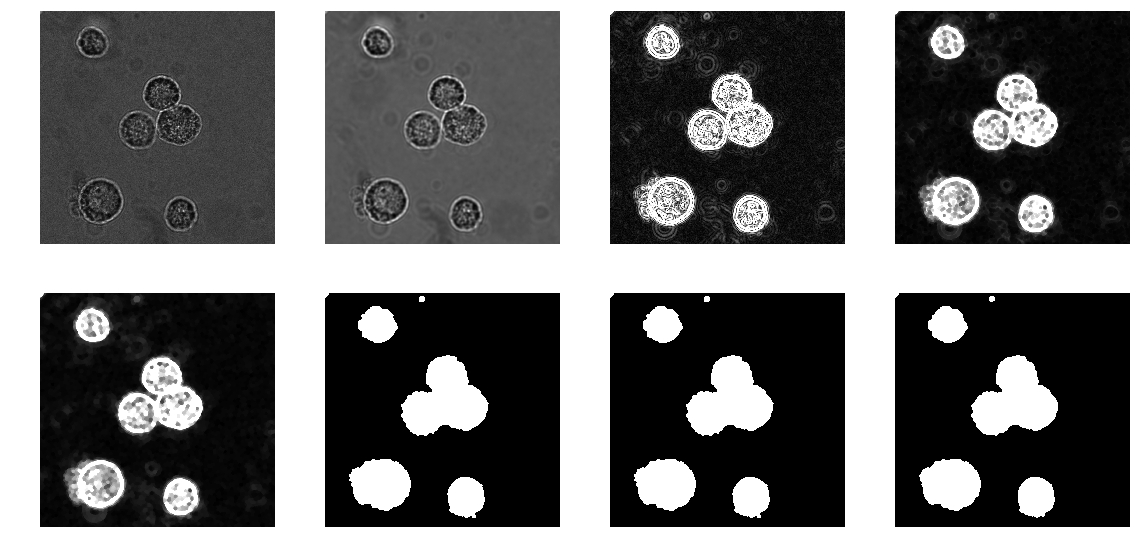

In [57]:
for prefix in to_track[2:3]:
    fstats = BF_cell_features(prefix, remote_folder)

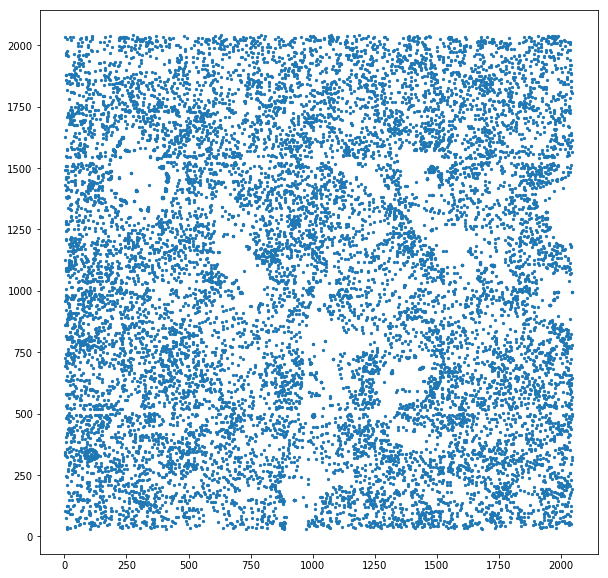

In [25]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(fstats['X'], fstats['Y'], s=5)
plt.show()

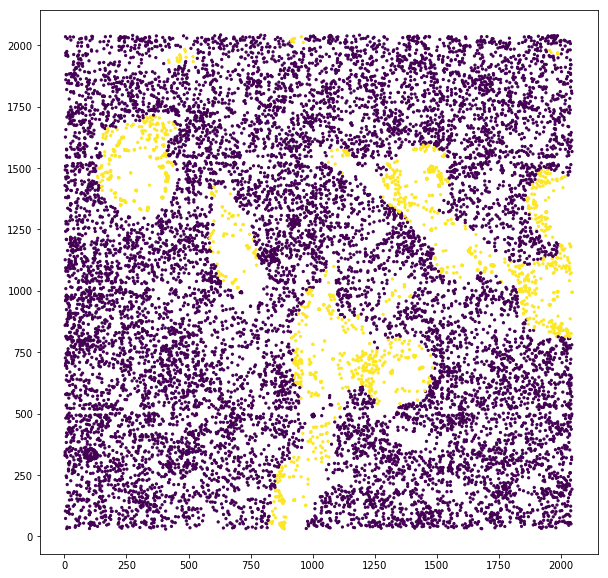

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(fstats['X'], fstats['Y'], c=fstats['Cell Status'], s=5)
plt.show()

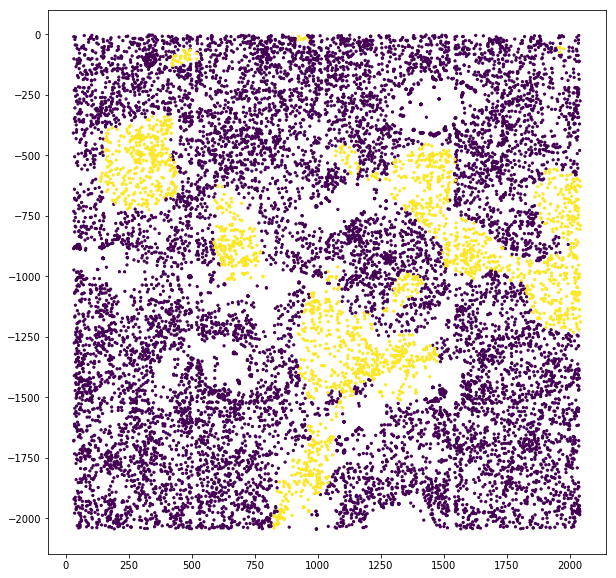

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(fstats['Y'], -fstats['X'], c=fstats['Cell Status'], s=5)
plt.show()

In [ ]:
prefix = to_track[0]
folder = remote_folder

ffilename = 'features_{}.csv'.format(prefix)
mfilename = 'msd_{}.csv'.format(prefix)
bffilename = 'BF_cells_{}.tif'.format(prefix)
biim = 'bi_BF_cells_{}.tif'.format(prefix)
bimages = 'biproc_BF_cells_{}.png'.format(prefix)

aws.download_s3('{}/{}'.format(folder, ffilename), ffilename, bucket_name=bucket)
aws.download_s3('{}/{}'.format(folder, mfilename), mfilename, bucket_name=bucket)
aws.download_s3('{}/{}'.format(folder, bffilename), bffilename, bucket_name=bucket)
print('Successfully downloaded files')

fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")
msds = pd.read_csv(mfilename, encoding = "ISO-8859-1")
bfimage = plt.imread(bffilename)
tophimage = binary_BF(bfimage, opense=disk(12), bi_thresh=1.2, tophatse=disk(20))
plt.savefig(bimages)
euimage = EuclideanTransform(tophimage)+EuclideanTransform(~tophimage)
print('Successfully performed image processing')

xa = np.reshape(np.clip((fstats.X.values-1).astype(int), a_min=0, a_max=2043), newshape=(fstats.X.shape[0], 1))
ya = np.reshape(np.clip((fstats.Y.values-1).astype(int), a_min=0, a_max=2043), newshape=(fstats.X.shape[0], 1))
xya = [tuple(l) for l in np.concatenate((xa, ya), axis=1).tolist()]
fstats['Cell Status'] = itemgetter(*xya)(tophimage)
fstats['Cell Distance'] = itemgetter(*xya)(euimage)

print('Successfully calculated Cell Status Params')

In [ ]:
frames = 651
xb = np.reshape(np.clip((msds.X.values-1).astype(int), a_min=0, a_max=2043), newshape=(int(msds.X.shape[0]), 1))
yb = np.reshape(np.clip((msds.Y.values-1).astype(int), a_min=0, a_max=2043), newshape=(int(msds.Y.shape[0]), 1))
xyb = [tuple(l) for l in np.concatenate((xb, yb), axis=1).tolist()]
msds['Cell Status'] = itemgetter(*xyb)(tophimage)
msds['Cell Distance'] = itemgetter(*xyb)(euimage)

In [ ]:
msds_cell_status = np.reshape(msds['Cell Status'].values, newshape=(int(msds.X.shape[0]/frames), frames))
msds_cell_distance = np.reshape(msds['Cell Distance'].values, newshape=(int(msds.X.shape[0]/frames), frames))
fstats['Membrane Xing'] = np.sum(np.diff(msds_cell_status, axis=1) == True, axis=1)
fstats['Distance Towards Cell'] = np.sum(np.diff(msds_cell_distance, axis=1), axis=1)
fstats['Percent Towards Cell'] = np.mean(np.diff(msds_cell_distance, axis=1) > 0, axis=1)